In [9]:
import math
import torch
import gpytorch
import seaborn as sns
import numpy as np
from control import *
from matplotlib import pyplot as plt
from IPython.display import display


sns.set_theme(style="darkgrid")

%matplotlib inline
%reload_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Generate State Space Training Data

torch.Size([100, 1])

torch.Size([100, 6])

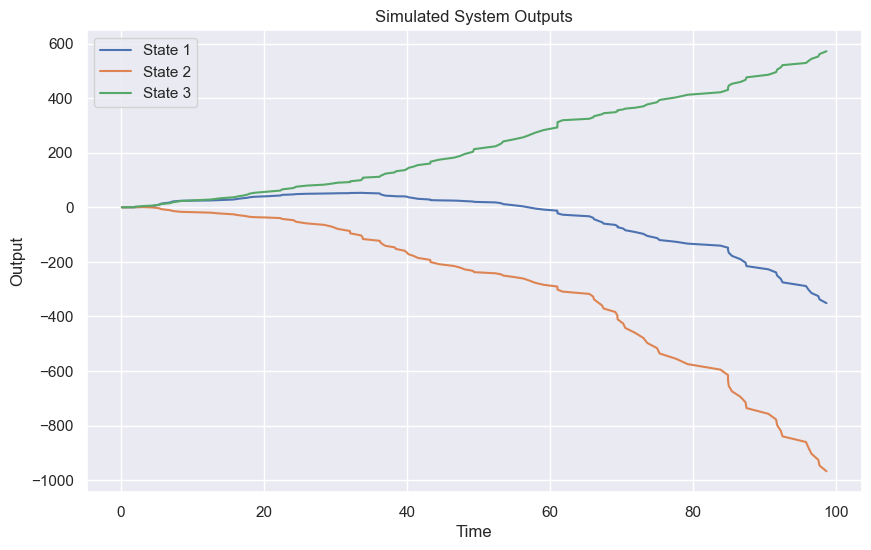

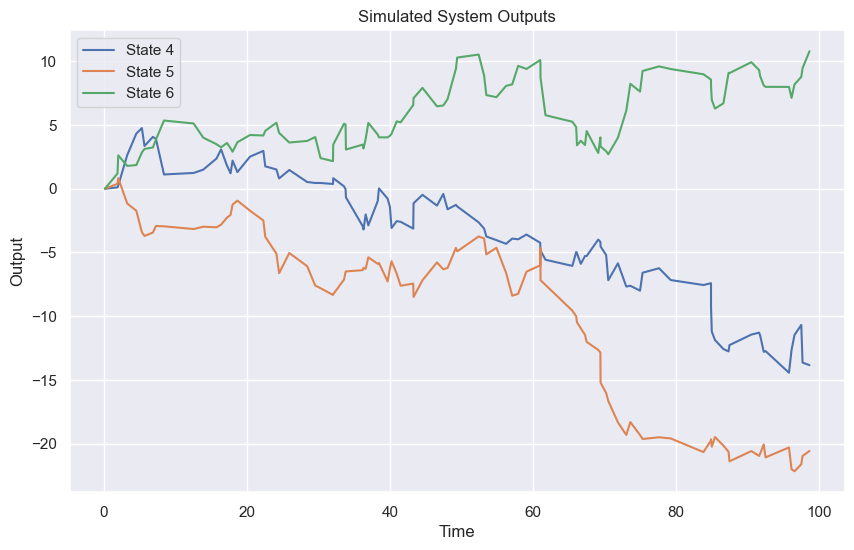

In [25]:
# Create SS Model
m=1.0
I=1.0
q=1.0
r=1.0
dt=1.0

M = np.diag([m, m, I])
A = np.zeros((6, 6))
A[0:3, 3:6] = np.eye(3)
B = np.zeros((6, 3))
B[3:6, 0:3] = np.diag([1/m, 1/m, 1/I])
C = np.eye(6)
D = np.zeros((6, 3))
sys = ss(A, B, C, D)
# print(sys)
# Discretize the system
sysd = c2d(sys, Ts=dt)
# print(sysd)

# t = np.linspace(0, 100, num=100)
t = np.sort(np.random.uniform(0, 100, size=100))  # Generate random time points and sort them

# Generate state-space dataset
X = t.reshape(-1, 1)  # Input is time
Y = []

# Initial state
x = np.zeros((6, 1))
for time in t:
    # Simulate the state-space model
    x_kp1 = sysd.A @ x + sysd.B @ (1 * np.random.randn(3, 1))  # Random input for simulation
    # print(x_kp1)
    y_k = sysd.C @ x + sysd.D @ np.random.randn(3, 1)  # Measurement with noise
    Y.append(y_k.flatten())
    
    x = x_kp1  # Update state for next iteration

Y = np.array(Y)  # Output is 6D measurement

# print(f"X: {X.shape}")
# print(f"Y: {Y.shape}")

# Define train data
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()

display(train_x.size())
display(train_y.size())

plt.figure(figsize=(10, 6))
for state in range(3):
    plt.plot(X, Y[:, state], label=f'State {state + 1}')
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('Simulated System Outputs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for state in range(3,6):
    plt.plot(X, Y[:, state], label=f'State {state + 1}')
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('Simulated System Outputs')
plt.legend()
plt.show()



# Setup up GP Model & Likelihood function

In [4]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Train Model

In [6]:
training_iter = 5

# Find optimal model hyperparameters
model.train()
likelihood.train()


# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

RuntimeError: The size of tensor a (6) must match the size of tensor b (100) at non-singleton dimension 1